In [5]:
import numpy as np
from scipy.stats import multivariate_normal as mvn

class GaussianMixtureModel():
    """Density estimation with Gaussian Mixture Models (GMM).

    You can add new functions if you find it useful, but **do not** change
    the names or argument lists of the functions provided.
    """
    def __init__(self, X, K):
        """Initialise GMM class.

        Arguments:
          X -- data, N x D array
          K -- number of mixture components, int
        """
        self.X = X
        self.n = X.shape[0]
        self.D = X.shape[1]
        self.K = K


    def E_step(self, mu, S, pi):
        """Compute the E step of the EM algorithm.

        Arguments:
          mu -- component means, K x D array
          S -- component covariances, K x D x D array
          pi -- component weights, K x 1 array

        Returns:
          r_new -- updated component responsabilities, N x K array
        """
        # Assert that all arguments have the right shape
        assert(mu.shape == (self.K, self.D) and\
               S.shape  == (self.K, self.D, self.D) and\
               pi.shape == (self.K, 1))
        r_new = np.zeros((self.n, self.K))

        # Task 1: implement the E step and return updated responsabilities
        # Write your code from here...

        for i in range(self.n): 
            Nk = 0
            for j in range(self.K):
                Nk += pi[j] * mvn.pdf((self.X)[i], mu[j], S[j], allow_singular=True)
            for k in range(self.K):
                r_new[i, k] = pi[k] * mvn.pdf((self.X)[i], mu[k], S[k], allow_singular=True)/ Nk
        
        # ... to here.
        assert(r_new.shape == (self.n, self.K))
        return r_new


    def M_step(self, mu, r):
        """Compute the M step of the EM algorithm.

        Arguments:
          mu -- previous component means, K x D array
          r -- previous component responsabilities,  N x K array

        Returns:
          mu_new -- updated component means, K x D array
          S_new -- updated component covariances, K x D x D array
          pi_new -- updated component weights, K x 1 array
        """
        assert(mu.shape == (self.K, self.D) and\
               r.shape  == (self.n, self.K))
        mu_new = np.zeros((self.K, self.D))
        S_new  = np.zeros((self.K, self.D, self.D))
        pi_new = np.zeros((self.K, 1))

        # Task 2: implement the M step and return updated mixture parameters
        # Write your code from here...

        #updating mu and pi
        for k in range(self.K):
            Nk = 0
            for j in range(self.n):
                Nk += r[j,k]
            for i in range(self.n):
                mu_new[k] += (r[i, k] * (self.X)[i])
            mu_new[k] /= Nk
            pi_new[k] = Nk/ (self.n)
        
        #updating S
        for k in range(self.K):
            Nk = 0
            for i in range(self.n): 
                Nk += r[i,k]
            for i in range(self.n):
                ys = np.reshape((self.X)[i]- mu_new[k], (-1,1))
                S_new[k] += (r[i, k] * (ys @ (ys.T)))
            S_new[k] /= Nk
        
        # ... to here.
        assert(mu_new.shape == (self.K, self.D) and\
               S_new.shape  == (self.K, self.D, self.D) and\
               pi_new.shape == (self.K, 1))
        return mu_new, S_new, pi_new

    
    def log_likelihood(self, pi, mu, S):
        '''Compute the loglikelihood'''
        
        ll = 0
        for i in range(self.n):
                s = 0
                for k in range(K):
                    s += pi[k] * mvn.pdf((self.X)[i], mu[k], S[k], allow_singular=True)
                ll += np.log(s)
        return -ll
    
    def train(self, initial_params):
        """Fit a Gaussian Mixture Model (GMM) to the data in matrix X.

        Arguments:
          initial_params -- dictionary with fields 'mu', 'S', 'pi' and 'K'

        Returns:kernel 
          mu -- component means, K x D array
          S -- component covariances, K x D x D array
          pi -- component weights, K x 1 array
          r -- component responsabilities, N x K array
        """
        # Assert that initial_params has all the necessary fields
        assert(all([k in initial_params for k in ['mu', 'S', 'pi']]))

        mu = np.zeros((self.K, self.D))
        S  = np.zeros((self.K, self.D, self.D))
        pi = np.zeros((self.K, 1))
        r  = np.zeros((self.n, self.K))

        # Task 3: implement the EM loop to train the GMM
        # Write your code from here...
        
        # updating log likelihoood
        eps = 1e-6  
        K = initial_params['K']
        mu = initial_params['mu']
        S = initial_params['S']
        pi = initial_params['pi']
        
        ll = 1
        previous_ll = 0
        
        while(np.abs(ll-previous_ll) > eps):       
            previous_ll = self.log_likelihood(pi, mu, S)
            
            r = self.E_step(mu, S, pi)
            mu, S, pi =  self.M_step(mu, r)
            ll = self.log_likelihood(pi, mu, S)
            print('diff', np.abs(ll-previous_ll))

        # ... to here.
        assert(mu.shape == (self.K, self.D) and\
               S.shape  == (self.K, self.D, self.D) and\
               pi.shape == (self.K, 1) and\
               r.shape  == (self.n, self.K))
        return mu, S, pi, r


if __name__ == '__main__':
    np.random.seed(43)

    ##########################
    # You can put your tests here - marking
    # will be based on importing this code and calling
    # specific functions with custom input.
    # Do not write code outside the class definition or
    # this if-block.
    ##########################

In [6]:
np.random.seed(123)

# create data set
n = 1000
_mu = np.array([[0,4], [-2,0]])
_S = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pi = np.array([0.6, 0.4]).reshape(-1,1)
X = np.concatenate([np.random.multivariate_normal(mu, S, int(pi*n))
                    for pi, mu, S in zip(_pi, _mu, _S)])

# initial values for parameters
pi = (np.random.random(2)).reshape(-1,1)
pi /= pi.sum()
mu = np.random.random((2,2)) 
S = np.array([np.eye(2)] * 2)

initial_params = {'mu':mu, 'S':S, 'pi': pi,'K': 2}

In [7]:
X.shape

(1000, 2)

In [8]:
K = 2
GMM = GaussianMixtureModel(X, K)

In [9]:
n = X.shape[0]
D = X.shape[1]
n,D

(1000, 2)

In [10]:
mu.shape #K*D

(2, 2)

In [11]:
S.shape #K*D*D

(2, 2, 2)

In [12]:
pi.shape #K

(2, 1)

In [13]:
r = GMM.E_step(mu, S, pi);r.shape

(1000, 2)

In [14]:
mu_new, S_new, pi_new = GMM.M_step(mu, r)
print(mu_new.shape, S_new.shape, pi_new.shape)

(2, 2) (2, 2, 2) (2, 1)


In [15]:
mu, S, pi, r = GMM.train(initial_params)

diff [4326.13082325]
diff [74.2080464]
diff [83.85693976]
diff [79.05562874]
diff [32.73050648]
diff [4.51355391]
diff [0.48024209]
diff [0.12911106]
diff [0.05632841]
diff [0.02579708]
diff [0.01172219]
diff [0.00527788]
diff [0.00236077]
diff [0.00105127]
diff [0.00046675]
diff [0.00020682]
diff [9.15211231e-05]
diff [4.04642151e-05]
diff [1.78799824e-05]
diff [7.89758315e-06]
diff [3.48746426e-06]
diff [1.53974588e-06]
diff [6.79734967e-07]


In [16]:
mu

array([[-0.02979884,  3.98051913],
       [-1.94734492,  0.01671157]])

In [17]:
S

array([[[3.02725263, 0.01334969],
        [0.01334969, 0.48308846]],

       [[0.90081832, 0.04724491],
        [0.04724491, 2.03467697]]])

In [18]:
pi

array([[0.59369597],
       [0.40630403]])

In [19]:
#import pandas as pd
import numpy as np
# df = pd.read_csv('geolocations.csv');df
df = np.loadtxt('geolocations.csv', delimiter = ',')
X = df 

In [20]:
import matplotlib.pyplot as plt

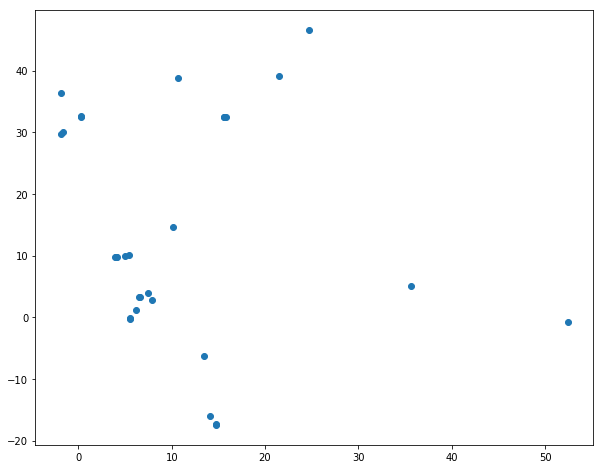

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(df[:,0],df[:,1], marker = 'o')
plt.show()

In [22]:
# initial values for parameters
K = 3
pi = (np.random.random(K)).reshape(-1,1)
pi /= pi.sum()
# mu = np.random.random((2,2)) 
S = np.array([i * np.eye(2) for i in range(1,4)])
i, j, k = 0,0,0
while i == j == k :
    i, j, k = np.random.randint(30), np.random.randint(30) , np.random.randint(30)
mu = np.array((df[i],df[j], df[k]))
initial_params = {'mu':mu, 'S':S, 'pi': pi,'K': K}

In [23]:
X_mean = X.mean(axis=0)

In [24]:
std_df = X.std(axis=0)

In [25]:
X_new = (X - X_mean)/std_df

In [26]:
X_new

array([[-0.40863952, -0.68777774],
       [-0.37199326, -0.57091008],
       [-0.46901162, -0.19772012],
       [ 0.30037516, -1.65005776],
       [ 2.20601045, -0.47349119],
       [-0.92919015,  1.04774405],
       [-0.46009757, -0.76575341],
       [ 0.43512475,  1.04810703],
       [ 0.35096429, -1.72779045],
       [ 0.35709148, -1.71935828],
       [-0.59618763, -0.21593262],
       [ 1.23861601,  1.83361819],
       [ 0.43528532,  1.04685074],
       [ 3.69819994, -0.79908575],
       [ 0.23865797, -1.1051358 ],
       [-0.5895571 , -0.21495582],
       [-0.05472302,  0.06057078],
       [-0.46054824, -0.76828709],
       [-1.12101115,  0.89765755],
       [-0.60436358, -0.215467  ],
       [-0.29348966, -0.54003919],
       [-0.25475684, -0.60308671],
       [ 0.9573232 ,  1.42110529],
       [-0.01049876,  1.39804825],
       [-1.09721788,  0.91651569],
       [-0.93243927,  1.05185087],
       [ 0.44722898,  1.05038734],
       [-0.37436416, -0.57216303],
       [-0.51435368,

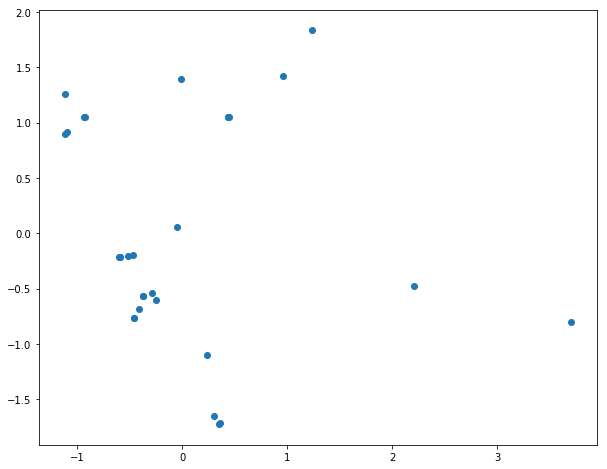

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(X_new[:,0],X_new[:,1], marker = 'o')
plt.show()

In [28]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [33]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X_new)
labels = gmm.predict(X_new)

/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecat

/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecat

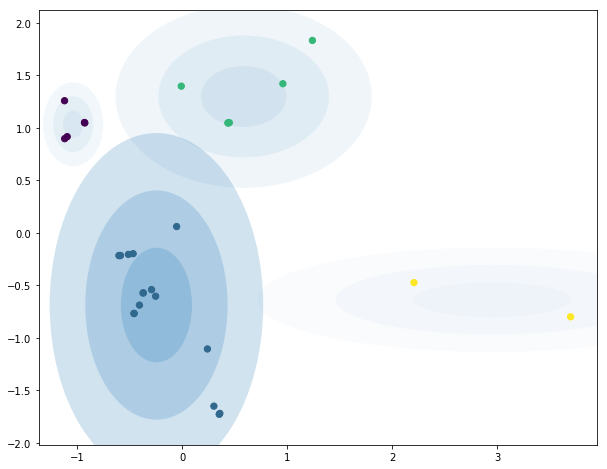

In [34]:
gmm = GMM(n_components=4, random_state=42)
plt.figure(figsize=(10,8))
plot_gmm(gmm, X_new)
plt.show()

In [36]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X_new, rng.randn(2, 2))

/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecat

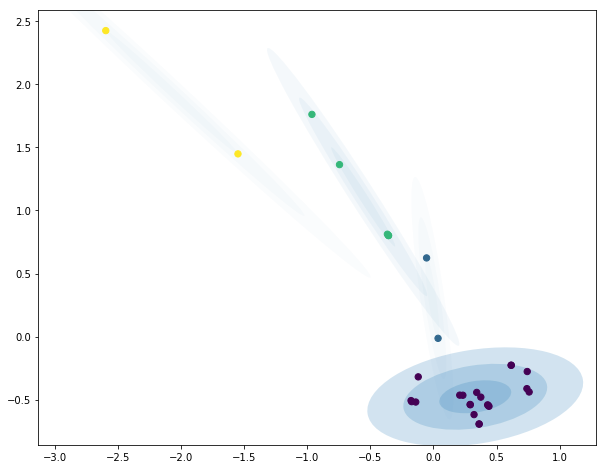

In [41]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plt.figure(figsize=(10,8))
plot_gmm(gmm, X_stretched)
plt.show()

In [61]:
# initial values for parameters
K = 3
pi = (np.random.random(K)).reshape(-1,1)
pi /= pi.sum()
# mu = np.random.random((2,2)) 
S = np.array([i * np.eye(2) for i in range(1,4)])
i, j, k = 0,0,0
while i == j == k :
    i, j, k = np.random.randint(30), np.random.randint(30) , np.random.randint(30)
mu = np.array((df_new[i],df_new[j], df_new[k]))
initial_params = {'mu':mu, 'S':S, 'pi': pi,'K': K}

In [ ]:
GMM_dff = GaussianMixtureModel(df_new, K)
mu_df, S_df, pi_df, r_df = GMM_dff.train(initial_params)

In [63]:
i,j,k

(16, 20, 4)

In [64]:
pi

array([[0.24615688],
       [0.38652058],
       [0.36732255]])

In [65]:
mu

array([[-0.05472302,  0.06057078],
       [-0.29348966, -0.54003919],
       [ 2.20601045, -0.47349119]])

In [66]:
S

array([[[1., 0.],
        [0., 1.]],

       [[2., 0.],
        [0., 2.]],

       [[3., 0.],
        [0., 3.]]])

In [67]:
GMM_df = GaussianMixtureModel(df, K)
mu_df, S_df, pi_df, r_df = GMM_df.train(initial_params)

diff [15.60498469]
diff [1.92296185]
diff [3.18151081]
diff [8.43958083]
diff [8.65561446]
diff [3.05666387]
diff [2.29436019]
diff [1.53973845]
diff [1.43012705]
diff [1.5739946]
diff [1.29483602]
diff [0.01932873]
diff [0.00043314]
diff [5.90356373e-05]
diff [8.46314652e-06]
diff [1.20564189e-06]
diff [1.71414278e-07]


In [68]:
mu_df

array([[ 0.5654303 ,  1.05744329],
       [-0.44488519, -0.31420158],
       [ 1.82838003,  0.13149947]])

In [69]:
S_df

array([[[ 0.19763727,  0.24402576],
        [ 0.24402576,  0.32384746]],

       [[ 0.20365851, -0.38171468],
        [-0.38171468,  0.78583563]],

       [[ 2.3073508 , -1.41946796],
        [-1.41946796,  0.93671078]]])

In [70]:
pi_df

array([[0.19340844],
       [0.69684561],
       [0.10974595]])